In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageFilter
import os
import time

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [3]:

class CardsDataSet(Dataset):
    
    def __init__(self, csv_file, transform=None, is_train=True):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.is_train = is_train
        print(self.data.columns)


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.data.iloc[idx]['filepaths']
        image = Image.open(img_path).convert('RGB')
        image = image.filter(ImageFilter.FIND_EDGES)
        image = image.resize((224, 224))
        image = np.array(image)
        image = image.astype(np.uint8)
        
        
        
        
        # Load label if in training mode
        if self.is_train:
            label = torch.tensor(int(self.data.iloc[idx]['class index']), dtype=torch.long)
            sample = {'image': image, 'label': label}
        else:
            sample = {'image': image}


        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
])


In [5]:
train_dataset = CardsDataSet('cards.csv', transform=transform,is_train=True)
print(f"Train Size: {len(train_dataset)}")

Index(['class index', 'filepaths', 'labels', 'card type', 'data set'], dtype='object')
Train Size: 8158


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]


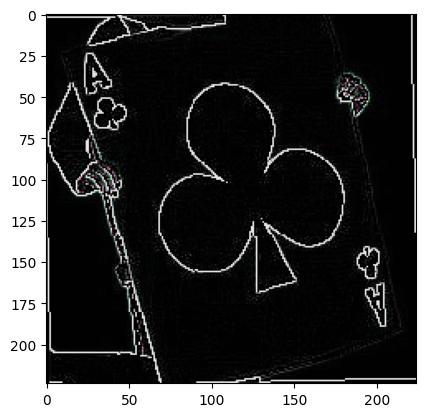

tensor(0)


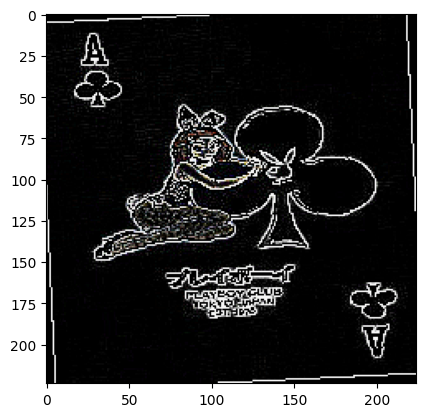

tensor(0)


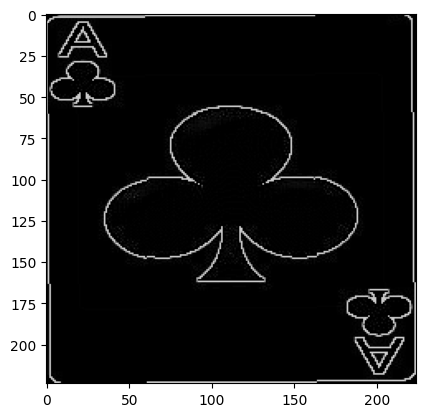

tensor(0)


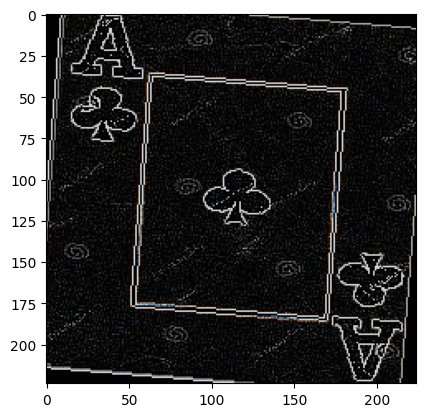

tensor(0)


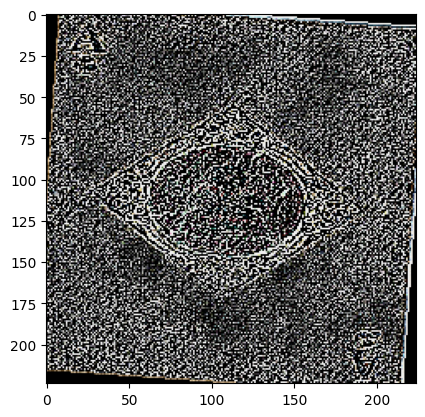

tensor(0)


In [6]:
train_loader = DataLoader(train_dataset,batch_size=25, shuffle=True)
print(f"{train_dataset.data['class index'].unique()}")


#print out the first image
sample = train_dataset[0]
plt.imshow(sample['image'].permute(1, 2, 0))
for i in range(5):
    sample = train_dataset[i]
    plt.imshow(sample['image'].permute(1, 2, 0))
    plt.show()
    print(sample['label'])

In [7]:
class CardRecognitionCNN(nn.Module):
    def __init__(self, num_classes=53):
        super(CardRecognitionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)

        # Global Average Pooling 3 of these
        self.fc1 = nn.Linear(64, 100)
        self.fc2 = nn.Linear(100, 128)
        self.fc3 = nn.Linear(128, num_classes)




    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = torch.mean(x, dim=[2, 3])  # Global Average Pooling
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [8]:
model = CardRecognitionCNN().to(device)
criterion = nn.CrossEntropyLoss() # This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class. 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [ ]:

num_epochs = 64
print(f"Training Started on {device}")
for epoch in range(num_epochs):
    running_loss = 0.0 
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data['image'], data['label']
        inputs, labels = inputs.to(device), labels.to(device)

        
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, "
                  f"Loss: {running_loss / 100:.4f}, "
                  f"Progress: {100 * (epoch + 1) / num_epochs:.2f}% ")
            

            running_loss = 0.0

print("Finished Training")

Training Started on cuda
Epoch: 1, Batch: 100, Loss: 3.8201, Progress: 1.56% 


In [ ]:
# Save the model
torch.save(model.state_dict(), 'model.pth')
print("Model Saved")

Model Saved
